In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib        as mpl

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def define_files():
    fname = '1_MCKNZ_1h_20170101_201701*'
    meshmaskname = '1_mesh_mask.nc'

    vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
    vosaline_ref_profile = vosaline_ref[0, :, 0, 0]
    
    return fname, meshmaskname, vosaline_ref_profile

def get_displace(dirname, dep_ind_slice, time_s):
    
    fname, meshmaskname, vosaline_ref_profile = define_files()
    
    time_f = time_s+24

    vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, dep_ind_slice, time_s, time_f, None)

    vosaline_daily = upwelling_functions.get_daily_vosaline(vosaline, tmask, None)

    depth_ind_daily = upwelling_functions.get_daily_depth_ind(vosaline_daily, vosaline_ref_profile)
    depth_m_daily, displace = upwelling_functions.get_daily_depth_m(deptht, dep_ind_slice, depth_ind_daily, tmask)
    
    print(displace.min(), displace.max())
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
    
    return displace, deptht, e1t, e2t

#deptht[1], deptht[9], deptht[13] = 13.125, 83.125, 118.125

In [3]:
def plot_upwelling(ax, up_filename):
    up = np.loadtxt(up_filename, delimiter=",")
    cm_times = np.linspace(0, 1, int(up.shape[0]*1.2))
    colors = [cmo.cm.matter(x) for x in cm_times]
    for i, c in zip(np.arange(up.shape[0]), colors[len(colors)-up.shape[0]:]):
        this_up = up[i, 1:]
        this_dep = up[i, 0]
        ax.plot(this_up, c=c, lw=2, marker='.', ms=8, label=str(int(np.round(this_dep, 0))))
    ax.set_xlabel('Time [hours]', fontsize=20)
    ax.set_ylabel('Maximum upward\ndisplacement [m]', fontsize=20)
    ax.xaxis.set_ticks(np.arange(0, 10*24, 12))
    ax.set_ylim([0, 200])
    ax.set_xlim([0, 132])
    ax.grid()
    ax.legend(loc=4, ncol=5, fontsize=17)
    ax.axhline(0, linestyle='-', c='darkgoldenrod', linewidth=1.5)
    return ax

In [4]:
def plot_panels(dirname, dep_ind_slice_all, time_s_day_all):
    
    vmins = [0, -20, -10]
    vmaxs = [120, 120, 140]
    levels = [-5, 5, 20, 40, 60]
   
    fig, axes = plt.subplots(5, 5, sharex=True, sharey = True, figsize=(20, 18),
                         gridspec_kw={'width_ratios': [5,5,5,0.2,0.1], 'height_ratios': [1,1,1,0.5,0.3]})

    for row in range(3):
        vmin = vmins[row]
        vmax = vmaxs[row]
        ticks = np.arange(-20, vmax+20, 20)
        
        for col in range(3):
            ttl = 'Hours '+str(time_s_day_all[col]+1)+'-'+str(time_s_day_all[col]+24+1)
            
            displace, deptht, e1t, e2t = get_displace(dirname, dep_ind_slice_all[row], time_s_day_all[col])
            print('loaded', dep_ind_slice_all[row], time_s_day_all[col])

            ax=axes[row, col]
            cmap, norm = cmo.cm.delta_r, upwelling_functions.MidpointNormalize(midpoint=0)
            cmap.set_bad('#8b7765')

#             xs = np.arange(displace.shape[-1])
#             ys = np.arange(displace.shape[-2])

            x_left, y_bottom = 0, 0
            print('x_left, y_bottom', x_left, y_bottom)
            x_shift, y_shift = x_left+e1t, y_bottom+e2t

            p = ax.pcolormesh(x_shift, y_shift, displace, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
            cs = ax.contour(x_shift, y_shift, displace, levels=levels, colors='k', alpha=0.7, linewidths=0.5)
            ax.clabel(cs, inline=1, fontsize=10, fmt ='%1.f', colors='k')

            ax.tick_params(axis='both', which='both', length=0)
            ax.set_aspect(aspect='equal')
#             ax.set_xlim([0, xs[-1]])
#             ax.set_ylim([0, ys[-1]])

            if row==0: ax.set_title(ttl, fontsize=25, y=1.08)
            else: pass

            if row==2: ax.set_xlabel('Alongshore (x)\ndistance [m]', fontsize=20)
            else:pass

            if col==0:
                ax.set_ylabel('Cross-shore (y)\ndistance [m]', fontsize=20)
                ax.annotate('Depth = '+str(int(np.round(deptht[dep_ind_slice_all[row]],0))),
                            xy=(0, 0.5), xytext=(-80, 0),
                            xycoords=('axes fraction'), textcoords='offset points',
                            size=25, ha='center', va='center', rotation='vertical')
            else: pass

        axc = axes[row, 3] 
        axc.axis('off')
        #cbar = fig.colorbar(p, ax=axc, orientation='vertical', fraction=5.5, aspect=15)
        
        
    for ax in axes[3, :]:
        ax.remove()
    for ax in axes[4, :]:
        ax.remove()
        
    ax = plt.subplot2grid((5,5), (4, 0), colspan=5, rowspan=1)
    if kind == 'ideal':
        up_filename = './files/upwelling_ideal_base.out'
    elif kind == 'real':
        up_filename = './files/upwelling_real_base.out'
    ax = plot_upwelling(ax, up_filename)
    ax.tick_params(axis='both', which='both', length=0, labelsize=15)

    fig.patch.set_facecolor('white')    
    fig.tight_layout(w_pad=0.5, h_pad=1.0)
    plt.subplots_adjust(top=0.96)
    return fig 

# Ideal

In [5]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'
vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, 9, 1, 10, None)

time_s_day1 = 24*0 + 11# day 1
time_s_day2 = 24*1 + 11# day 2
time_s_day4 = 24*3 + 11# day 4


time_s_day_all = [time_s_day1, time_s_day2, time_s_day4]
dep_ind_slice_all = [1, 9, 18]

0
50
100
150
200
0.0 26.25
loaded 1 11
x_left, y_bottom 0 0
0
50
100
150
200
0.0 61.25
loaded 1 35
x_left, y_bottom 0 0
0
50
100
150
200
0.0 113.75
loaded 1 83
x_left, y_bottom 0 0
0
50
100
150
200
-8.75 43.75
loaded 9 11
x_left, y_bottom 0 0
0
50
100
150
200
-17.5 105.0
loaded 9 35
x_left, y_bottom 0 0
0
50
100
150
200
-8.75 113.75
loaded 9 83
x_left, y_bottom 0 0
0
50
100
150
200
0.0 43.75
loaded 18 11
x_left, y_bottom 0 0
0
50
100
150
200
0.0 148.75
loaded 18 35
x_left, y_bottom 0 0
0
50
100
150
200
0.0 148.75
loaded 18 83
x_left, y_bottom 0 0


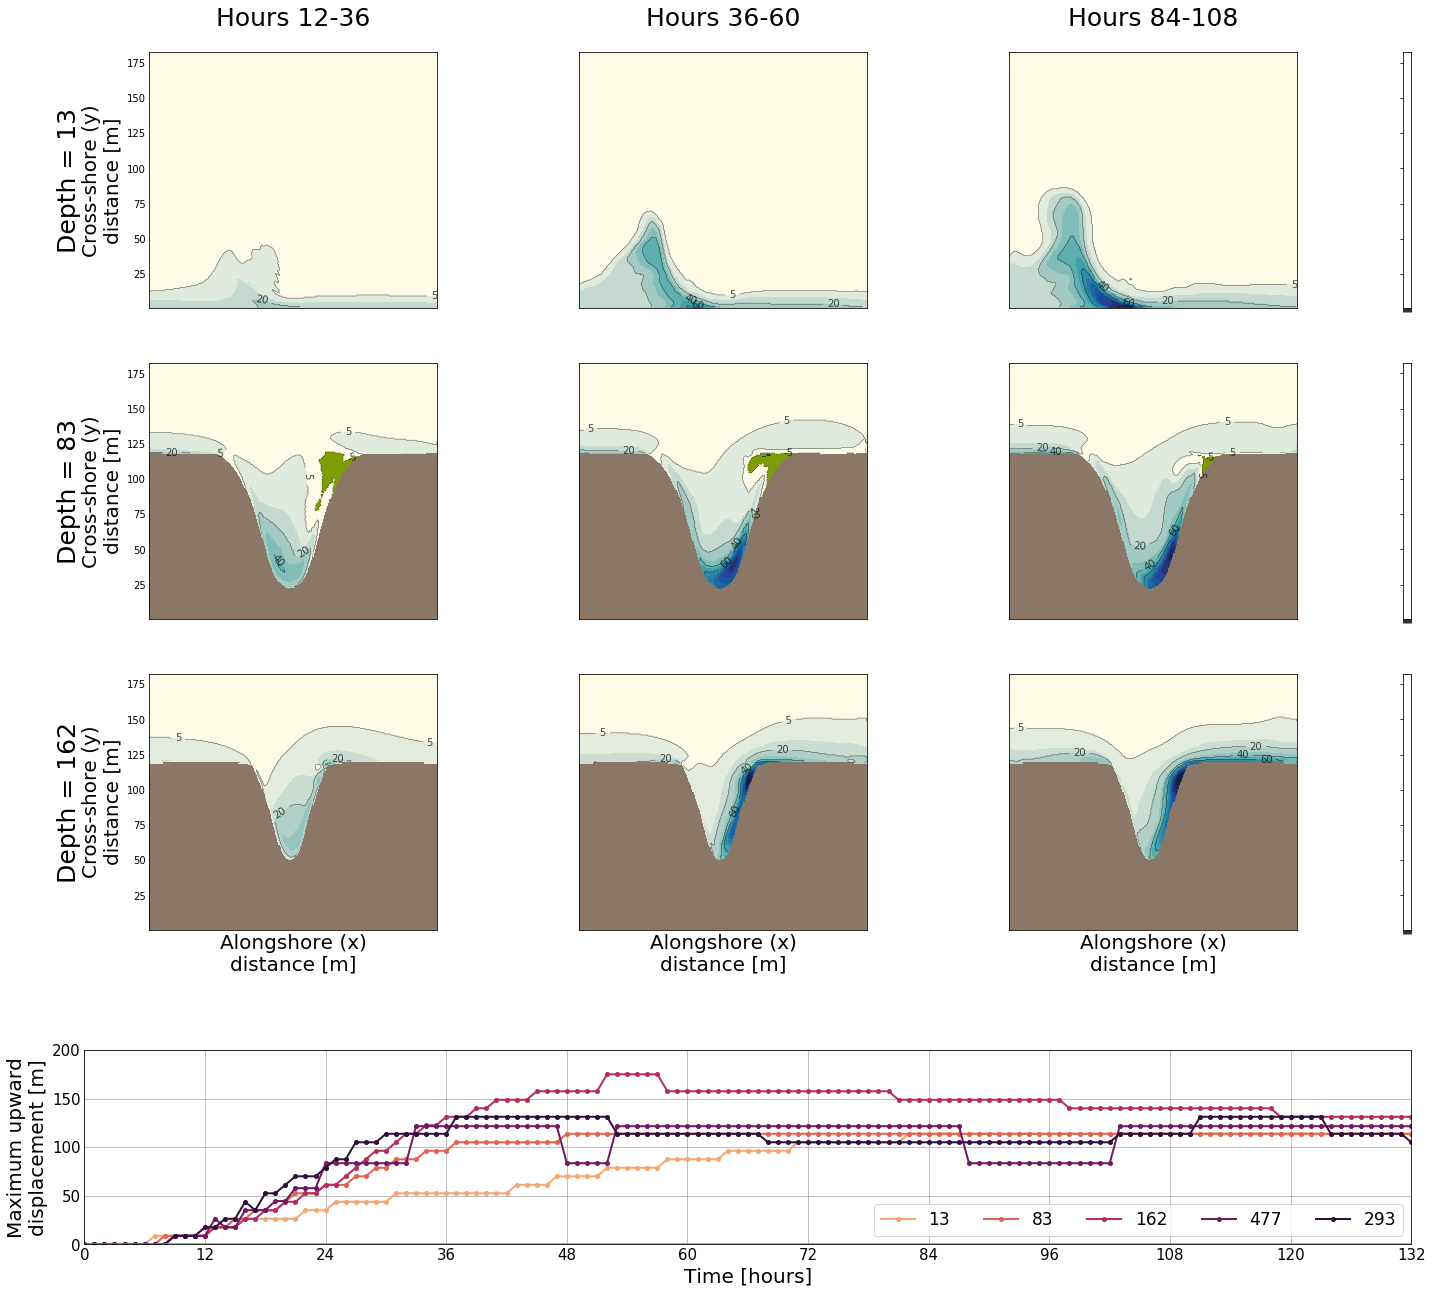

In [6]:
fig = plot_panels(dirname, dep_ind_slice_all, time_s_day_all)
fig.savefig('./slice_displacement_ideal.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

# Real

# Save